Python code for generating figures used in the paper "What Determines the Sizes of Bars in Spiral Galaxies?" (Erwin 2019, submitted)

## Setup

### General Setup

In [1]:
%pylab inline

matplotlib.rcParams['figure.figsize'] = (8,6)
matplotlib.rcParams['xtick.labelsize'] = 16
matplotlib.rcParams['ytick.labelsize'] = 16
matplotlib.rcParams['axes.labelsize'] = 20

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/IPython/core/magics/pylab.py:162: UserWarning: pylab import has clobbered these variables: ['mean']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [149]:
import os, math
import numpy as np
import scipy.stats
from astropy.io import fits

# local modules
import angle_utils as angles
import plotutils as pu
import barprofile_utils as barprof_utils

# CHANGE THIS TO POINT TO APPROPRIATE LOCAL DIRECTORY (DEFAULT = SAME DIRECTORY AS THIS NOTEBOOK)
#projDir = '/Users/erwin/Documents/Working/Papers/Paper-BarProfiles/public/'
projDir = os.getcwd() + "/"
sys.path.append(projDir)
import datautils as du

# The following is from Eqn. 2 of Sheth+2010 (http://adsabs.harvard.edu/abs/2010PASP..122.1397S)
# where zeroPoint_s4g is the AB mag zero point, assuming data values are MJy sr^-1, and the next
# two values are the effective zero points converting pixel values to surface brightness for images
# with 0.75 arcsec/pixel (S4G images) and 0.6 arcsec/pixel (Spitzer archival images), respectively.
zeroPoint_s4g = 20.472
zeroPoint_sb_075 = zeroPoint_s4g + 2.5*np.log10(0.75**2)
zeroPoint_sb_060 = zeroPoint_s4g + 2.5*np.log10(0.6**2)

dataDir = projDir + "data/"
imagesDir = dataDir + "images/"
s4gdata = du.ReadCompositeTable(dataDir + "s4gbars_table.dat", columnRow=29, dataFrame=True)

nDisksTotal = len(s4gdata.name)

# Sample definition files for the two main subsamples
bpDetectionSampleFile = dataDir + "s4gbars_bp-buckling_profiles_checklist.dat"
faceonSampleFile = dataDir + "s4g_faceon_names.dat"


# This is where the best-fit parameter coefficients are saved
bestfitParamsFile = projDir + "bestfit_parameters.txt"

# CHANGE THIS TO POINT TO APPROPRIATE LOCAL DIRECTORY -- this is where PDF figures will be saved
baseDir = "/Users/erwin/Documents/Working/Papers/Paper-BarProfiles/"
plotDir = baseDir + "plots/"

mm = np.arange(8,12,0.01)

# set the following to True in order to save the figures as PDF files
savePlots = False

## Useful Code

### Plot labels

In [119]:
# useful definitions for printing and plotting labels

xtmstar = r"$\log \: (M_{\star} / M_{\odot})$"
xtfgas = r"$\log \: (M_{\rm HI} / M_{\star})$"
xtHtype = r"Hubble Type $T$"
xtgmr = r"$g - r$"
xtbarsize = r"Relative bar size $(a_{\rm dp} / h)$"
ytmu = r"$\mu_{3.6}$ [AB mag arcsec$^{-2}$]"
pshLabel = "Peak+Sh"

s4g_txt = r"S$^{4}$G"

In [141]:
def GetYLimits( radii, intensityProfile, ZP=None ):
    if ZP is None:
        maxVal = max(intensityProfile)
        minVal = min(intensityProfile)
        if (minVal < 1.0e-3):
            minVal = 1.0e-3
        minVal = 10**(math.floor(math.log10(minVal)))
        maxVal = 10**(math.ceil(math.log10(maxVal)))
    else:
        sbProfile = ZP - 2.5*np.log10(intensityProfile)
        # "min" and "max" for surface-brightness
        minVal = math.ceil(np.nanmax(sbProfile))
        maxVal = math.floor(np.nanmin(sbProfile))
    return (minVal, maxVal)


def MakeIsophoteAndProfilePlots( fname, xc,yc, imageWidth, diskPA, inclination, barPA, sma,
            boxPA, r_box, profileRadius, pixSize=0.75, ZP=None,
            squareProfPlot=False, axisLabelSize=9, figMode="standard" ):
    """
    Make a two-panel plot, with isophotes on left side and bar-major + bar-minor profile
    plots on right side.
    
    Parameters
    ----------
    fname : str
        path to image file
        
    xc, yc : int, int
        x- and y-coordinates of galaxy center within image
    
    imageWidth : int
        width of contour plot, in pixels
    
    diskPA, inclination : float, float
        PA and inclination of galaxy disk, in degrees
    
    barPA : float
        PA of bar on image, in degrees
    
    sma : float
        semi-major axis of bar (observed), in arcsec
    
    boxPA : float
        PA of B/P on image, in degrees
    
    r_box : float
        semi-major axis of B/P bulge (observed), in arcsec
        (set = 0 for no B/P bulge)
    
    profileRadius : float
        radius for bar-major-axis and bar-minor-axis profiles, in pixels
    
    pixSize : float, optional
        pixel size in arcsec
    
    ZP : float, optional or None
        zero point for converting data values (counts/pix) into surface-brightness
        (mag/arcsec^2)
    
    figMode : str, optional
        "standard" = for Figs.3--5 in paper
        "nice" = for Fig.1 in paper
    """

    levs = np.arange(-1.5,2.5,0.1)

    rbox_dp = angles.deprojectr(boxPA - diskPA, inclination, r_box)

    rr_barmaj,ii_barmaj = pu.GetProfileAtAngle(fits.getdata(fname), xc,yc, barPA + 90, profileRadius, width=1, oneSided=False)
    rr_barmaj = 1.0 + np.arange(len(rr_barmaj))
    rr_barmaj_arcsec = 0.75*(rr_barmaj - (profileRadius + 0.5))

    deprojFactor_majoraxis = angles.deprojectr(barPA - diskPA, inclination, 1.0)
    rr_barmaj_arcsec_dp = deprojFactor_majoraxis * rr_barmaj_arcsec

    # 2. Get bar-minor-axis profile and compute deprojected radii
    barMinorPA_obs = angles.minoraxis(barPA, diskPA, inclination)
    rr_barmin,ii_barmin = pu.GetProfileAtAngle(fits.getdata(fname), xc,yc, barMinorPA_obs + 90, profileRadius, width=1, oneSided=False)
    rr_barmin = 1.0 + np.arange(len(rr_barmin))
    rr_barmin_arcsec = 0.75*(rr_barmin - (profileRadius + 0.5))
    deprojFactor_minoraxis = angles.deprojectr(barMinorPA_obs - diskPA, inclination, 1.0)
    rr_barmin_arcsec_dp = deprojFactor_minoraxis * rr_barmin_arcsec


    # 3. Get image data and plot contours   [left, bottom, width, height]
    imdata_m3 = median_filter(fits.getdata(fname), 3)
    fig = figure(figsize=(10,4))
    if figMode == "nice":   # e.g. Fig.1 of paper
        ax1 = fig.add_axes([0.05,0.15, 0.35,0.8])   # left, bottom, width, height
    else:
        ax1 = fig.add_axes([0.07,0.15, 0.35,0.8])   # left, bottom, width, height
    pu.nicecont(imdata_m3, xc,yc,1.5*profileRadius, log=True,levels=levs,
                            pix=pixSize, printAxisLabels='x',axisLabel='arcsec',
                            labelSize=axisLabelSize, color='0.4', axesObj=ax1)
    # Draw major-axis PA line, bar radius, minor-axis PA line
    pu.DrawPALine(barPA, 0.5*profileRadius, fmt='b-', linewidth=1.5, alpha=0.75, axesObj=ax1)
    pu.DrawPALine(barPA, sma, fmt='b-', alpha=0.5, addDots=True, dot_ms=8, axesObj=ax1)
    pu.DrawPALine(barMinorPA_obs, 0.5*profileRadius, 'b--', alpha=0.75, axesObj=ax1)
    ax1.axhline(0, color='0.5', linewidth=0.5)
    ax1.axvline(0, color='0.5', linewidth=0.5)
    # add red arrow for B/P bulge, if present
    if (rbox_dp > 0.0):
        arrowWidth = 0.035 * imageWidth*pixSize
        arrowLWidth = 0.002 * imageWidth*pixSize
        pu.DrawArrow((0,0), PA=boxPA, radius=r_box, lineWidth=2*arrowLWidth, headWidth=arrowWidth, color='r')
        pu.DrawArrow((0,0), PA=boxPA + 180, radius=r_box, lineWidth=2*arrowLWidth, headWidth=arrowWidth, color='r')


    # Profile plot   [left, bottom, width, height]
    # this (assuming figsize = ()) gets us the approximate standard 1.3 aspect ratio
    # of a matplotlib plot
    ax2 = fig.add_axes([0.55,0.15, 0.42,0.8])
    if ZP is None:
        ax2.semilogy(rr_barmaj_arcsec_dp, ii_barmaj, "k")
        ax2.semilogy(rr_barmin_arcsec_dp, ii_barmin, "0.5", lw=0.5)
        ylimits = ax2.get_ylim() #ylim( blah, blah )
        if (ylimits[0] < 0.01):
            ax2.set_ylim([0.001, ylimits[1]])
    else:
        mags_barmaj = ZP - 2.5*np.log10(ii_barmaj)
        mags_barmin = ZP - 2.5*np.log10(ii_barmin)
        ax2.plot(rr_barmaj_arcsec_dp, mags_barmaj, "k")
        ax2.plot(rr_barmin_arcsec_dp, mags_barmin, "0.5", lw=0.5)
        ylimits = ax2.get_ylim()
        ax2.set_ylim(ylimits[1], ylimits[0])
    ax2.axvline(0, color='k', linestyle=":")
    ax2.axvline(deprojFactor_majoraxis*sma, color="b")
    ax2.axvline(-deprojFactor_majoraxis*sma, color="b")
    if (rbox_dp > 0.0):
        ax2.axvline(rbox_dp, color='r');plt.axvline(-rbox_dp, color='r')

    # trim x-axis range to include bar-major-axis profile; don't worry about
    # extended (deprojected) minor-axis profile
    xLimit = 1.1*max(rr_barmaj_arcsec_dp)
    yLimits = GetYLimits(rr_barmaj_arcsec_dp, ii_barmaj, ZP=ZP)
    ax2.set_xlim(-xLimit, xLimit)
    ax2.set_ylim(yLimits[0], yLimits[1])
    ax2.set_xlabel("Deprojected radius [arc sec]", fontsize=axisLabelSize)
    if ZP is None:
        ytitle = "Intensity"
    else:
        ytitle = ytmu
    ax2.set_ylabel(ytitle, fontsize=axisLabelSize)


def GetNames( filename ):
    dlines = [line for line in open(filename) if len(line) > 1 and line[0] != '#']
    names = []
    for line in dlines:
        if line[:3] != "[-]":
            gname = line.split()[0][3:]
            names.append(gname.strip())
    return names


def logistic( x, a, b ):
    """Calculates the standard linear logistic function (probability distribution)
    for x (which can be a scalar or a numpy array).
    """
    
    return 1.0 / (1.0 + np.exp(-(a + b*x)))


### Definitions of subsamples

Most of this is defining vectors of indices, used to subset arrays in the s4gdata data-frame.

In [128]:
ii_spirals = [i for i in range(nDisksTotal) if s4gdata['t_s4g'][i] > -0.5]
ii_all_limited1 = [i for i in ii_spirals if s4gdata.dist[i] <= 25]
ii_barred_limited1 = [i for i in ii_all_limited1 if s4gdata.sma_kpc[i] > 0]

modinc_names = GetNames(bpDetectionSampleFile)
nModInc = len(modinc_names)   # 131 galaxies
faceon_names = GetNames(faceonSampleFile)
all_names = modinc_names + faceon_names

ii_modinc = [i for i in range(nDisksTotal) if s4gdata.name[i] in modinc_names]
ii_faceon = [i for i in range(nDisksTotal) if s4gdata.name[i] in faceon_names]
ii_main = ii_modinc + ii_faceon

# Figures

Most of the figures in the paper are composites (assembled in Adobe Illustrator). Code for the individual panels that make up each figure is provided below.

## Figure 1 -- Examples of Peak+Shoulder Bar Profiles

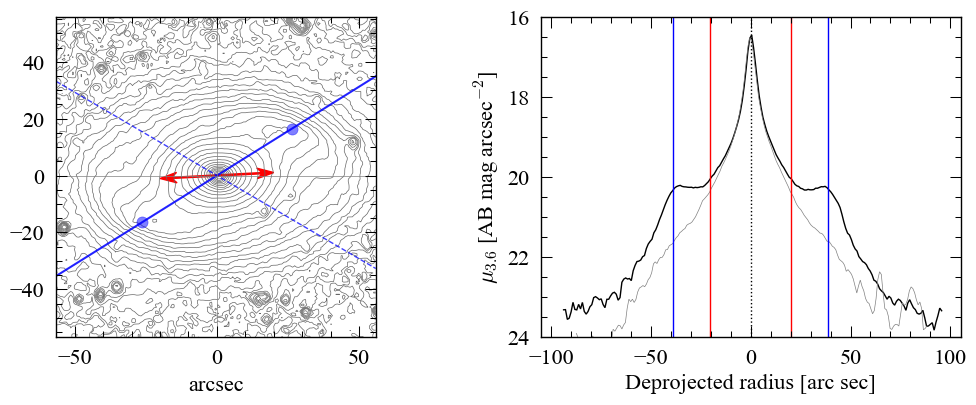

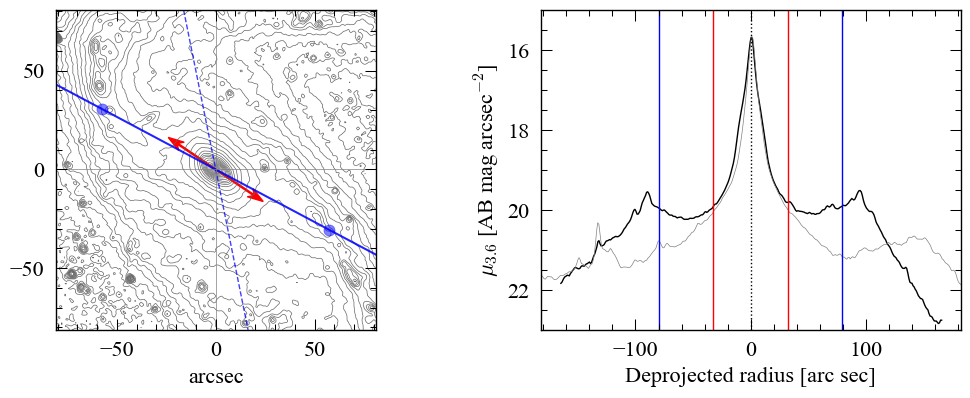

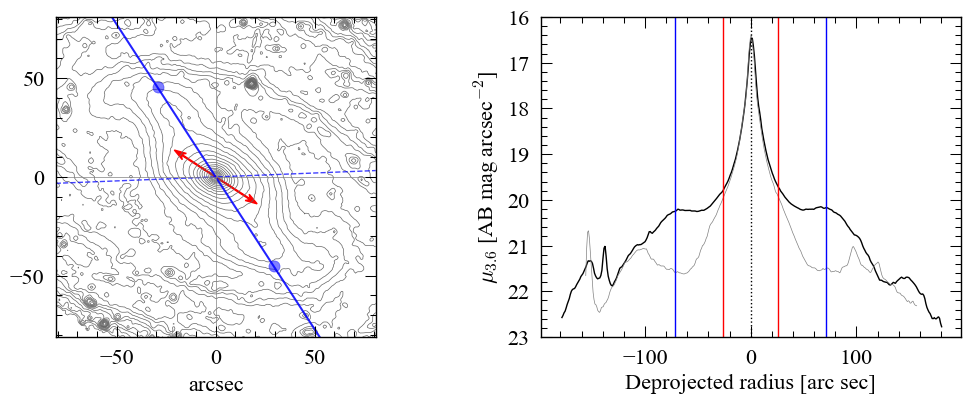

In [30]:
matplotlib.rcParams['xtick.labelsize'] = 16
matplotlib.rcParams['ytick.labelsize'] = 16

# NGC 1079
fname0 = imagesDir + "n1079irac1ss.fit"
pixSize0 = 0.75
imageWidth0 = 140
diskPA0, inc0 = 87, 53
barPA0, sma0 = 122, 31
boxPA0, r_box0 = 93, 20
MakeIsophoteAndProfilePlots(fname0, 295.56,286.67, imageWidth0, diskPA0, inc0, barPA0, 
sma0, boxPA0, r_box0, 100, pixSize=pixSize0, ZP=zeroPoint_s4g, axisLabelSize=16, figMode="nice")
if savePlots:
    savefig(fplots + "n1079_isophotes+profiles.pdf")

# NGC 2442
fname1 = imagesDir + "n2442irac1_derot_cutout.fit"
pixSize1 = 0.6
imageWidth1 = 240
diskPA1, inc1 = 40, 62
barPA1, sma1 = 62, 65
boxPA1, r_box1 = 56, 29
MakeIsophoteAndProfilePlots(fname1, 438.,411.4, imageWidth1, diskPA1, inc1, barPA1, 
sma1, boxPA1, r_box1, 180, pixSize=pixSize1, ZP=zeroPoint_s4g, axisLabelSize=16, figMode="nice")
if savePlots:
    savefig(fplots + "n2442_isophotes+profiles.pdf")

# NGC 3992
fname2 = imagesDir + "n3992irac1_derot_cutout_ss.fit"
pixSize2 = 0.6
imageWidth2 = 180
diskPA2, inc2 = 69, 56
barPA2, sma2 = 33, 54
boxPA2, r_box2 = 57, 25
MakeIsophoteAndProfilePlots(fname2, 742,742, imageWidth2, diskPA2, inc2, barPA2, 
sma2, boxPA2, r_box2, 180, pixSize=pixSize2, ZP=zeroPoint_s4g, axisLabelSize=16, figMode="nice")
if savePlots:
    savefig(fplots + "n3992_isophotes+profiles.pdf")


## Figure 2 -- Distributions of Stellar Mass

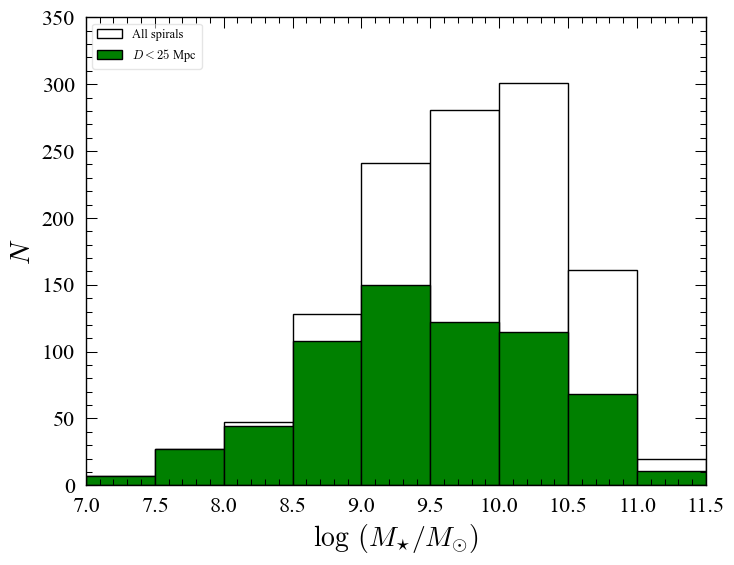

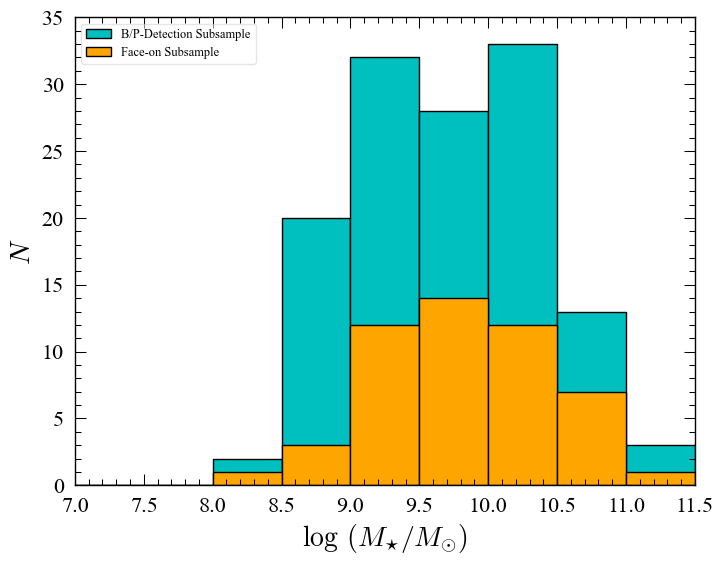

In [84]:
close(1);figure(1)
clf();hist(s4gdata.logmstar[ii_spirals], bins=np.arange(7,12,0.5), color='1.0', label="All spirals", edgecolor='k')
hist(s4gdata.logmstar[ii_all_limited1], bins=np.arange(7,12,0.5), color='g', edgecolor='k', label=r"$D < 25$ Mpc")
xlabel(xtmstar);ylabel(r"$N$")
legend(fontsize=9, loc='upper left', framealpha=0.5)
subplots_adjust(bottom=0.12)
if savePlots:
    savefig(fplots+"sample_hist_logmstar.pdf")

figure(2);clf();hist(s4gdata.logmstar[ii_modinc], bins=np.arange(7,12,0.5), color='c', edgecolor='k', label="B/P-Detection Subsample")
hist(s4gdata.logmstar[ii_faceon], bins=np.arange(7,12,0.5), color='orange', edgecolor='k', label="Face-on Subsample")
xlabel(xtmstar);ylabel(r"$N$")
legend(fontsize=9, loc='upper left', framealpha=0.5)
subplots_adjust(bottom=0.12)
if savePlots:
    savefig(fplots+"subsamples_hist_logmstar.pdf")


## Figure 3 -- Examples of Exponental Bar Profiles

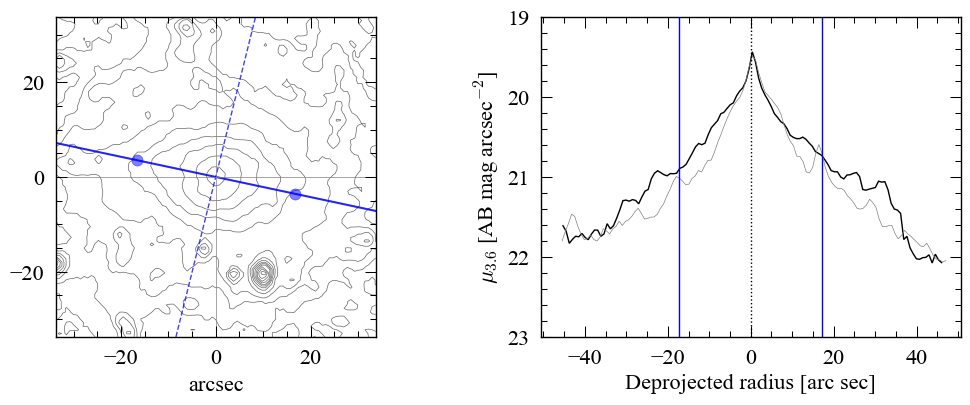

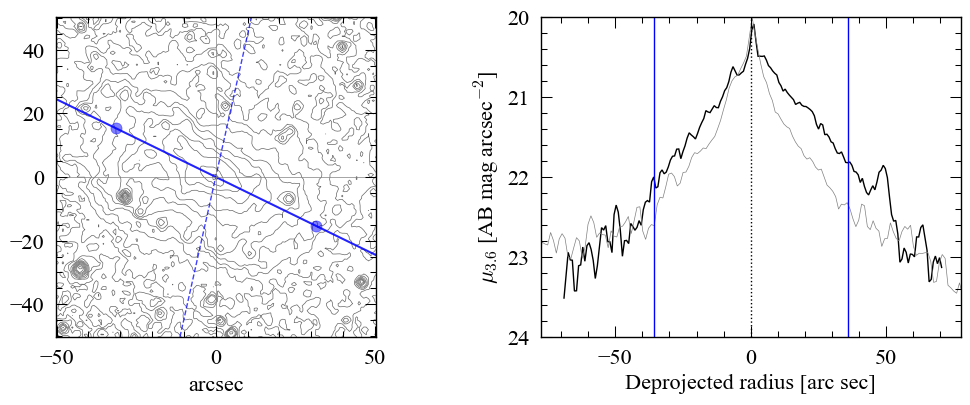

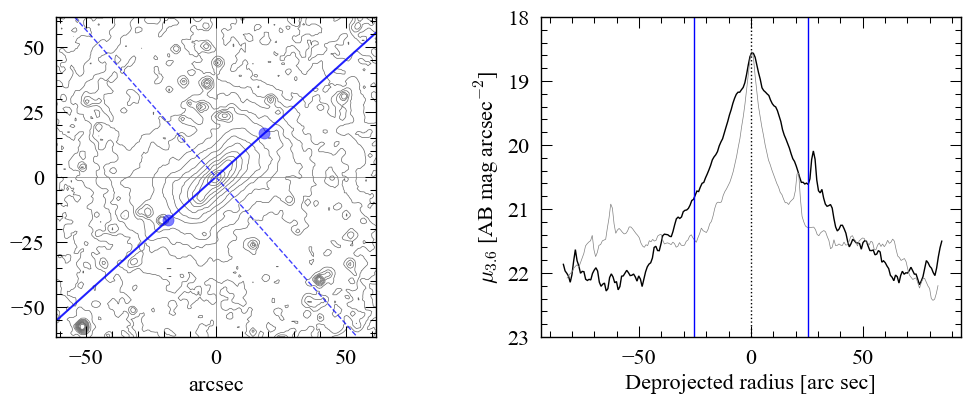

In [50]:
matplotlib.rcParams['xtick.labelsize'] = 16
matplotlib.rcParams['ytick.labelsize'] = 16

# NGC 991
fname0 = fspit+"n991irac1/n991irac1_srh2010.fits"
pixSize0 = 0.75
imageWidth0 = 140
diskPA0, inc0 = 118,15
barPA0, sma0 = 78, 17
boxPA0, r_box0 = 0,0
MakeIsophoteAndProfilePlots(fname0, 274,280, imageWidth0, diskPA0, inc0, barPA0, sma0, 
boxPA0, r_box0, 60, pixSize=pixSize0, ZP=zeroPoint_sb_075, axisLabelSize=16, figMode="nice")
if savePlots:
    savefig(fplots + "n991_isophotes+profiles.pdf")

# NGC 1879
fname0 = fspit+"n1879irac1/n1879irac1_srh2010.fits"
pixSize0 = 0.75
imageWidth0 = 140
diskPA0, inc0 = 52,48
barPA0, sma0 = 64,34.9
boxPA0, r_box0 = 0,0
MakeIsophoteAndProfilePlots(fname0, 402,269, imageWidth0, diskPA0, inc0, barPA0, sma0, 
boxPA0, r_box0, 90, pixSize=pixSize0, ZP=zeroPoint_sb_075, axisLabelSize=16, figMode="nice")
if savePlots:
    savefig(fplots + "n1879_isophotes+profiles.pdf")

# NGC 7424
fname0 = fspit+"n7424irac1/n7424irac1_srh2010.fits"
pixSize0 = 0.75
imageWidth0 = 140
diskPA0, inc0 = 29,12
barPA0, sma0 = 132,25
boxPA0, r_box0 = 0,0
MakeIsophoteAndProfilePlots(fname0, 712,1099, imageWidth0, diskPA0, inc0, barPA0, sma0, 
boxPA0, r_box0, 110, pixSize=pixSize0, ZP=zeroPoint_sb_075, axisLabelSize=16, figMode="nice")
if savePlots:
    savefig(fplots + "n7424_isophotes+profiles.pdf")


## Figure 4 -- Examples of Two-Slope Bar Profiles

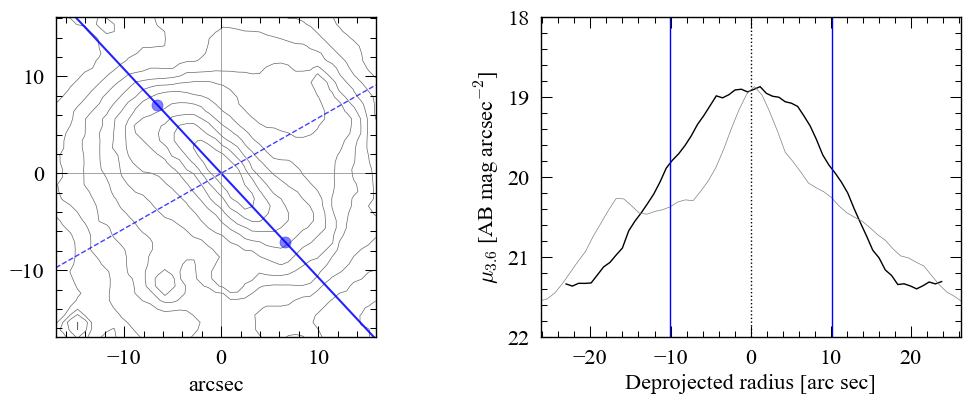

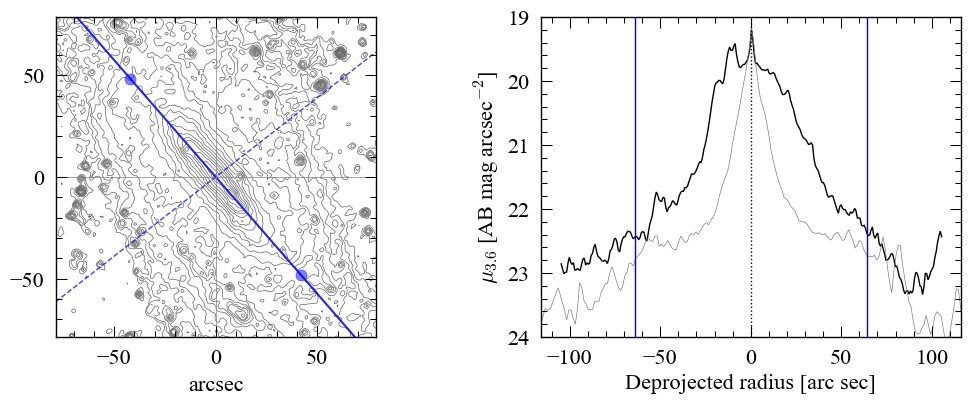

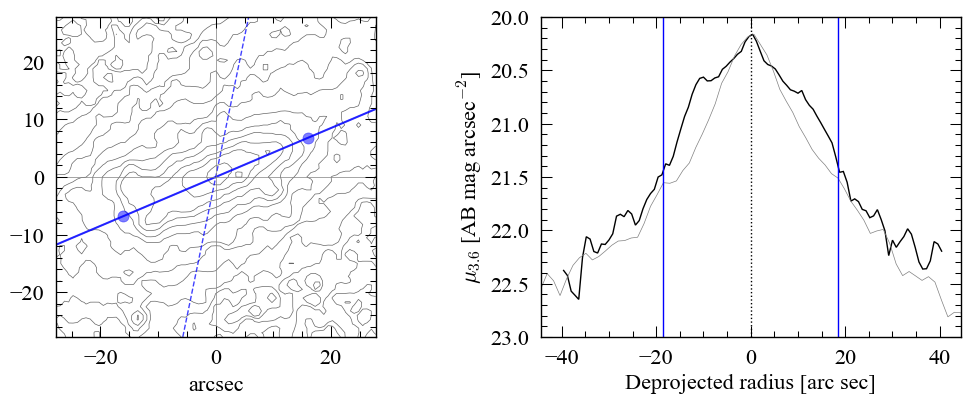

In [51]:
# NGC 5669
fname0 = fspit+"n5669irac1/n5669irac1ss.fit"
pixSize0 = 0.75
imageWidth0 = 60
diskPA0, inc0 = 61, 43
barPA0, sma0 = 43, 9.7
boxPA0, r_box0 = 0,0
MakeIsophoteAndProfilePlots(fname0, 384.75,292.5, imageWidth0, diskPA0,inc0, barPA0,sma0, 
boxPA0,r_box0, 30, pixSize=pixSize0, ZP=zeroPoint_sb_075, axisLabelSize=16, figMode="nice")
if savePlots:
    savefig(fplots + "n5669_isophotes+profiles.pdf")

# NGC 3319
fname0 = fspit+"n3319irac1/n3319irac1ss.fit"
pixSize0 = 0.75
imageWidth0 = 240
diskPA0, inc0 = 43, 51
barPA0, sma0 = 41,64
boxPA0, r_box0 = 0,0
MakeIsophoteAndProfilePlots(fname0, 471,257, imageWidth0, diskPA0, inc0, barPA0, sma0, 
boxPA0, r_box0, 140, pixSize=pixSize0, ZP=zeroPoint_sb_075, axisLabelSize=16, figMode="nice")
if savePlots:
    savefig(fplots + "n3319_isophotes+profiles.pdf")


# NGC 3850
fname0 = fspit+"n3850irac1/n3850irac1_srh2010.fits"
pixSize0 = 0.75
imageWidth0 = 100
diskPA0, inc0 = 123, 65
barPA0, sma0 = 113,17.4
boxPA0, r_box0 = 0,0
MakeIsophoteAndProfilePlots(fname0, 687,299, imageWidth0, diskPA0, inc0, barPA0, sma0, 
boxPA0, r_box0, 50, pixSize=pixSize0, ZP=zeroPoint_sb_075, axisLabelSize=16, figMode="nice")
if savePlots:
    savefig(fplots + "n3850_isophotes+profiles.pdf")


## Figure 5 -- Examples of Flat-Top Bar Profiles

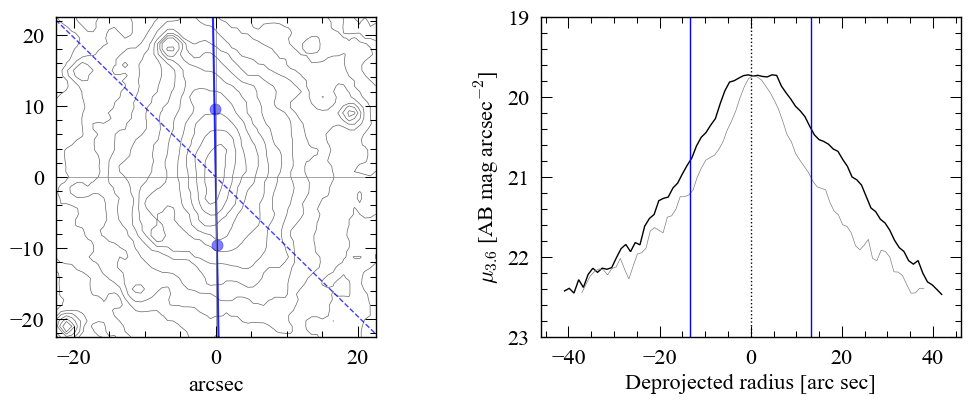

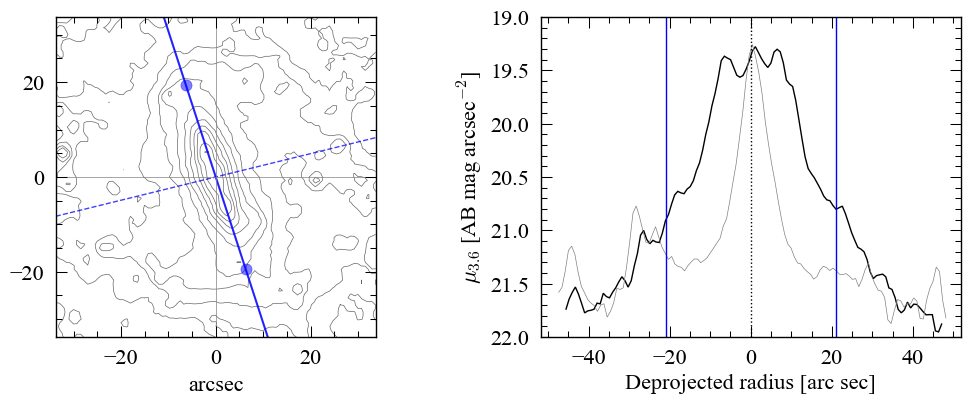

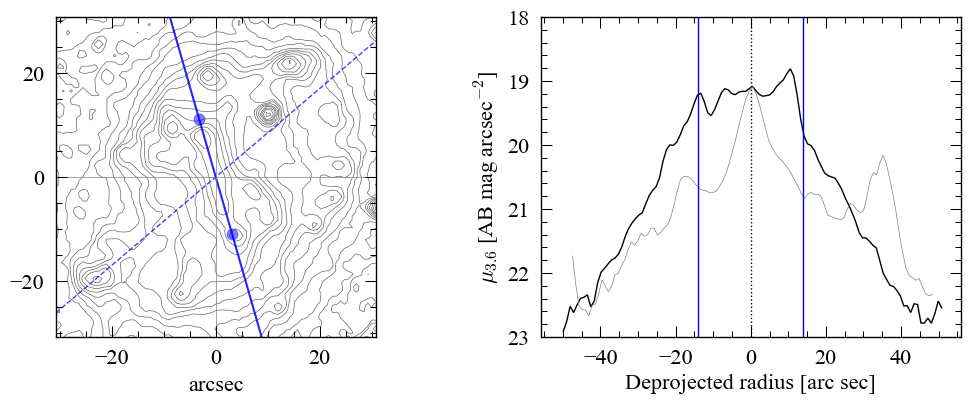

In [52]:
# IC 600
fname0 = fspit+"ic600irac1/ic600irac1_srh2010.fits"
pixSize0 = 0.75
imageWidth0 = 60
diskPA0, inc0 = 26,66
barPA0, sma0 = 1,9.6
boxPA0, r_box0 = 0,0
MakeIsophoteAndProfilePlots(fname0, 465,787, imageWidth0, diskPA0, inc0, barPA0, sma0, 
boxPA0, r_box0, 40, pixSize=pixSize0, ZP=zeroPoint_sb_075, axisLabelSize=16, figMode="nice")
if savePlots:
    savefig(fplots + "ic600_isophotes+profiles.pdf")

# NGC 600
fname0 = fspit+"n600irac1/n600irac1_srh2010.fits"
pixSize0 = 0.75
imageWidth0 = 100
diskPA0, inc0 = 47,23
barPA0, sma0 = 18,20.5
boxPA0, r_box0 = 0,0
MakeIsophoteAndProfilePlots(fname0, 286,275, imageWidth0, diskPA0, inc0, barPA0, sma0, 
boxPA0, r_box0, 60, pixSize=pixSize0, ZP=zeroPoint_sb_075, axisLabelSize=16, figMode="nice")
if savePlots:
    savefig(fplots + "n600_isophotes+profiles.pdf")

# NGC 7764
fname0 = fspit+"n7764irac1/n7764irac1_srh2010.fits"
pixSize0 = 0.75
imageWidth0 = 100
diskPA0, inc0 = 160,50
barPA0, sma0 = 16,11.5
boxPA0, r_box0 = 0,0
MakeIsophoteAndProfilePlots(fname0, 756,613, imageWidth0, diskPA0, inc0, barPA0, sma0, 
boxPA0, r_box0, 55, pixSize=pixSize0, ZP=zeroPoint_sb_075, axisLabelSize=16, figMode="nice")
if savePlots:
    savefig(fplots + "n7764_isophotes+profiles.pdf")


## Figure 6 -- Stellar-mass Distributions of Bar-Profile Types

In [88]:
stellarMassDict_main = {s4gdata.name[i]: s4gdata.logmstar[i] for i in range(nDisksTotal) if i in ii_main}

pd = barprof_utils.GetClassifications(barprof_utils.classificationsFile_pe, barprof_utils.scrambleMap)
vd = barprof_utils.GetClassifications(barprof_utils.classificationsFile_vd2, barprof_utils.scrambleMap)

massesDict_pe, massesDict_lowinc_pe, massesDict_modinc_pe = barprof_utils.MakeValuesDict(pd, stellarMassDict_main, faceon_names)
massesDict_vd, massesDict_lowinc_vd, massesDict_modinc_vd = barprof_utils.MakeValuesDict(vd, stellarMassDict_main, faceon_names)

massesDict = {'pe': massesDict_pe, 'vd': massesDict_vd}
massesDict_lowinc = {'pe': massesDict_lowinc_pe, 'vd': massesDict_lowinc_vd}
massesDict_modinc = {'pe': massesDict_modinc_pe, 'vd': massesDict_modinc_vd}

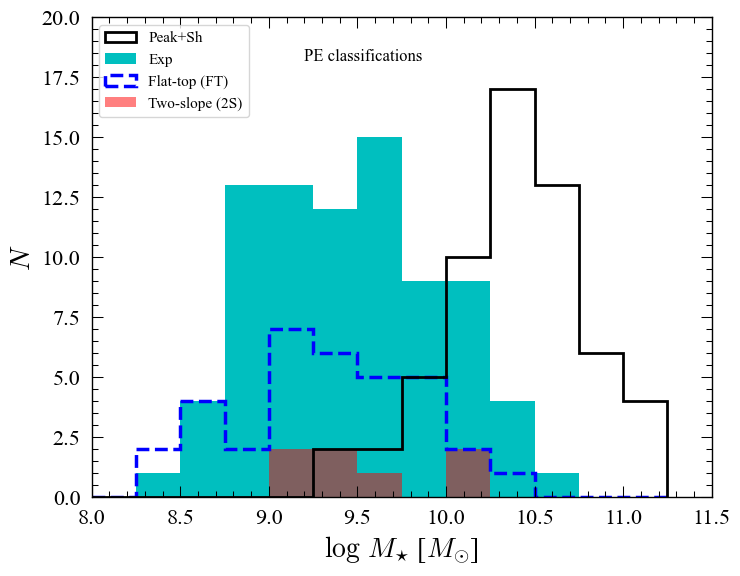

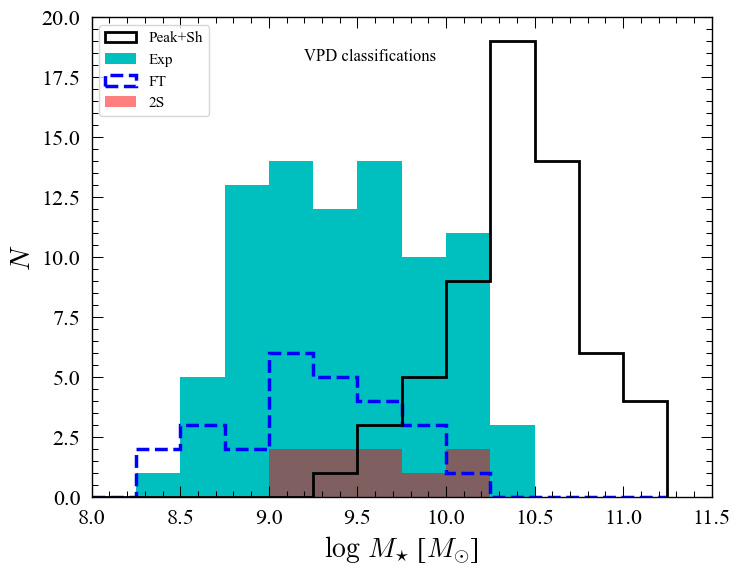

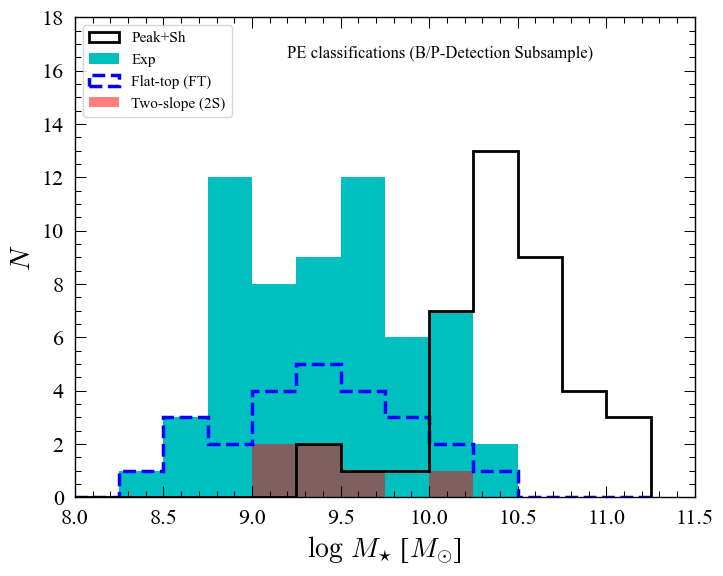

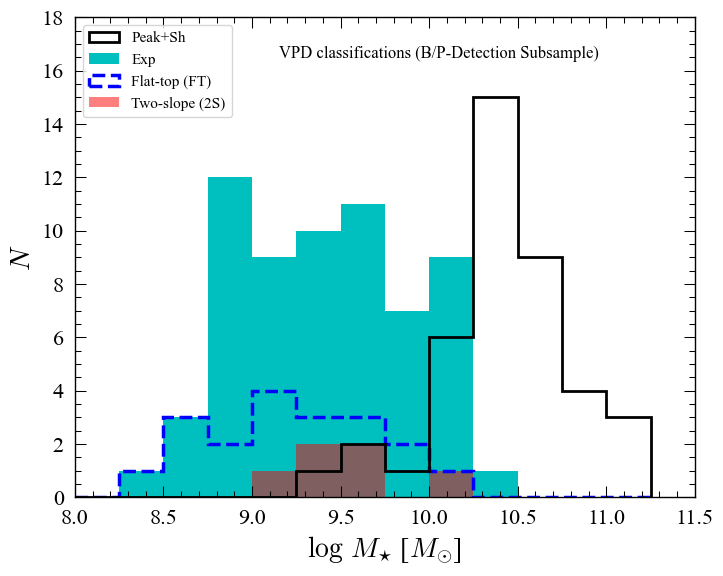

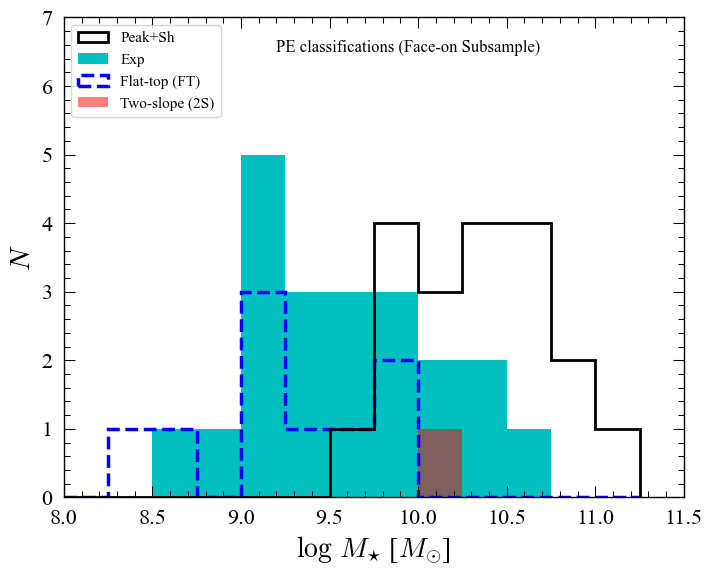

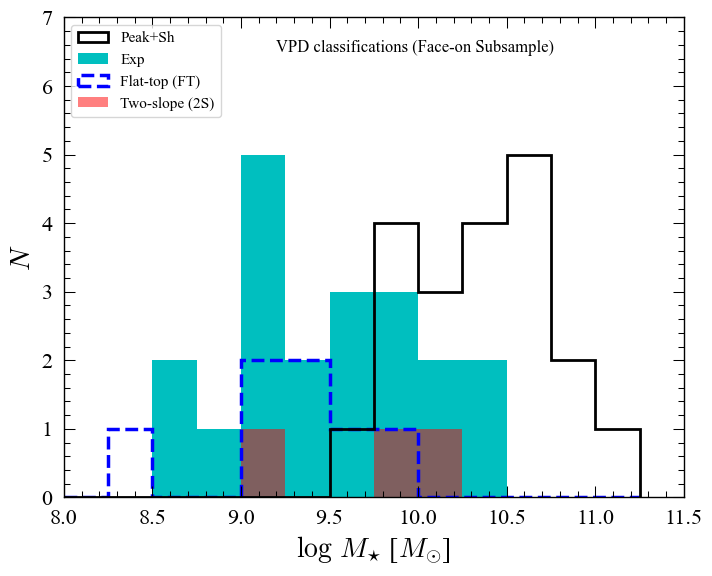

In [101]:
bins_logmstar = np.arange(8.0,11.5,0.25)

hist(massesDict['pe']['Exp'], bins=bins_logmstar, color='c', label='Exp')
hist(massesDict['pe']['FT'], bins=bins_logmstar, histtype='step', color='b', lw=2.5, ls='--', label='Flat-top (FT)')
hist(massesDict['pe']['2S'], bins=bins_logmstar, color='r', label='Two-slope (2S)', alpha=0.5)
hist(massesDict['pe']['BP'], bins=bins_logmstar, histtype='step', color='k', lw=2, label=pshLabel)
ylim(0,20)
handles, labels = plt.gca().get_legend_handles_labels()
handles = [handles[3], handles[0], handles[1], handles[2]]
labels = [labels[3], labels[0], labels[1], labels[2]]
legend(handles, labels, loc='upper left', fontsize=11)
xlabel(r"$\log \, M_{\star}$ [$M_{\odot}$]");ylabel(r"$N$")
text(9.2,18.2, "PE classifications", fontsize=12)
if savePlots:
    savefig(fplots+"logmstar_distributions_pe-classif.pdf")

figure();hist(massesDict['vd']['Exp'], bins=bins_logmstar, color='c', label='Exp')
hist(massesDict['vd']['FT'], bins=bins_logmstar, histtype='step', color='b', lw=2.5, ls='--', label='FT')
hist(massesDict['vd']['2S'], bins=bins_logmstar, color='r', label='2S', alpha=0.5)
hist(massesDict['vd']['BP'], bins=bins_logmstar, histtype='step', color='k', lw=2, label='Peak+Sh')
ylim(0,20)
handles, labels = plt.gca().get_legend_handles_labels()
handles = [handles[3], handles[0], handles[1], handles[2]]
labels = [labels[3], labels[0], labels[1], labels[2]]
legend(handles, labels, loc='upper left', fontsize=11)
xlabel(r"$\log \, M_{\star}$ [$M_{\odot}$]");ylabel(r"$N$")
text(9.2,18.2, "VPD classifications", fontsize=12)
if savePlots:
    savefig(fplots+"logmstar_distributions_vpd-classif.pdf")

figure();hist(massesDict_modinc['pe']['Exp'], bins=bins_logmstar, color='c', label='Exp')
hist(massesDict_modinc['pe']['FT'], bins=bins_logmstar, histtype='step', color='b', lw=2.5, ls='--', label='Flat-top (FT)')
hist(massesDict_modinc['pe']['2S'], bins=bins_logmstar, color='r', label='Two-slope (2S)', alpha=0.5)
hist(massesDict_modinc['pe']['BP'], bins=bins_logmstar, histtype='step', color='k', lw=2, label=pshLabel)
ylim(0,18)
handles, labels = plt.gca().get_legend_handles_labels()
handles = [handles[3], handles[0], handles[1], handles[2]]
labels = [labels[3], labels[0], labels[1], labels[2]]
legend(handles, labels, loc='upper left', fontsize=11)
xlabel(r"$\log \, M_{\star}$ [$M_{\odot}$]");ylabel(r"$N$")
text(9.2,16.5, "PE classifications (B/P-Detection Subsample)", fontsize=12)
if savePlots:
    savefig(fplots+"logmstar_distributions_pe-classif_modinc.pdf")

figure();hist(massesDict_modinc['vd']['Exp'], bins=bins_logmstar, color='c', label='Exp')
hist(massesDict_modinc['vd']['FT'], bins=bins_logmstar, histtype='step', color='b', lw=2.5, ls='--', label='Flat-top (FT)')
hist(massesDict_modinc['vd']['2S'], bins=bins_logmstar, color='r', label='Two-slope (2S)', alpha=0.5)
hist(massesDict_modinc['vd']['BP'], bins=bins_logmstar, histtype='step', color='k', lw=2, label=pshLabel)
ylim(0,18)
handles, labels = plt.gca().get_legend_handles_labels()
handles = [handles[3], handles[0], handles[1], handles[2]]
labels = [labels[3], labels[0], labels[1], labels[2]]
legend(handles, labels, loc='upper left', fontsize=11)
xlabel(r"$\log \, M_{\star}$ [$M_{\odot}$]");ylabel(r"$N$")
text(9.15,16.5, "VPD classifications (B/P-Detection Subsample)", fontsize=12)
if savePlots:
    savefig(fplots+"logmstar_distributions_vd-classif_modinc.pdf")

figure();hist(massesDict_lowinc['pe']['Exp'], bins=bins_logmstar, color='c', label='Exp')
hist(massesDict_lowinc['pe']['FT'], bins=bins_logmstar, histtype='step', color='b', lw=2.5, ls='--', label='Flat-top (FT)')
hist(massesDict_lowinc['pe']['2S'], bins=bins_logmstar, color='r', label='Two-slope (2S)', alpha=0.5)
hist(massesDict_lowinc['pe']['BP'], bins=bins_logmstar, histtype='step', color='k', lw=2, label=pshLabel)
ylim(0,7)
handles, labels = plt.gca().get_legend_handles_labels()
handles = [handles[3], handles[0], handles[1], handles[2]]
labels = [labels[3], labels[0], labels[1], labels[2]]
legend(handles, labels, loc='upper left', fontsize=11)
xlabel(r"$\log \, M_{\star}$ [$M_{\odot}$]");ylabel(r"$N$")
text(9.2,6.5, "PE classifications (Face-on Subsample)", fontsize=12)
if savePlots:
    savefig(fplots+"logmstar_distributions_pe-classif_lowinc.pdf")

figure();hist(massesDict_lowinc['vd']['Exp'], bins=bins_logmstar, color='c', label='Exp')
hist(massesDict_lowinc['vd']['FT'], bins=bins_logmstar, histtype='step', color='b', lw=2.5, ls='--', label='Flat-top (FT)')
hist(massesDict_lowinc['vd']['2S'], bins=bins_logmstar, color='r', label='Two-slope (2S)', alpha=0.5)
hist(massesDict_lowinc['vd']['BP'], bins=bins_logmstar, histtype='step', color='k', lw=2, label=pshLabel)
ylim(0,7)
handles, labels = plt.gca().get_legend_handles_labels()
handles = [handles[3], handles[0], handles[1], handles[2]]
labels = [labels[3], labels[0], labels[1], labels[2]]
legend(handles, labels, loc='upper left', fontsize=11)
xlabel(r"$\log \, M_{\star}$ [$M_{\odot}$]");ylabel(r"$N$")
text(9.2,6.5, "VPD classifications (Face-on Subsample)", fontsize=12)
if savePlots:
    savefig(fplots+"logmstar_distributions_vd-classif_lowinc.pdf")


## Figure 7 -- Distributions of Bar-Profile Types Versus T, gas mass fraction, and g-r

In [105]:
ii_s4g_psh_both, ii_s4g_nonpsh_both = barprof_utils.GetS4gIndices(pd, s4gdata, vd)
ii_s4g_exp_both, junk = barprof_utils.GetS4gIndices(pd, s4gdata, vd, profType='Exp')
ii_s4g_ft_both, junk = barprof_utils.GetS4gIndices(pd, s4gdata, vd, profType='FT')
ii_s4g_2s_both, junk = barprof_utils.GetS4gIndices(pd, s4gdata, vd, profType='2S')

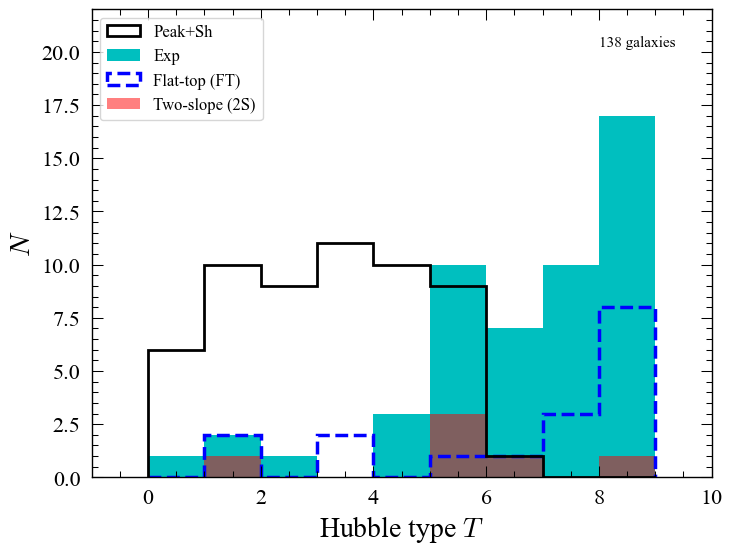

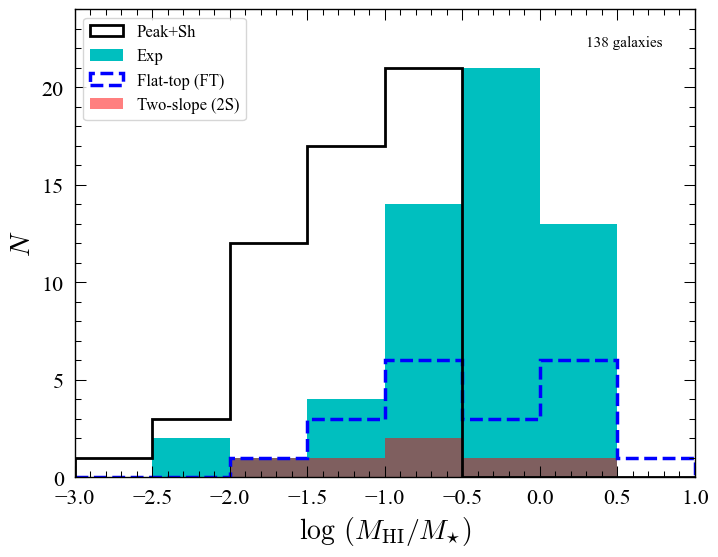

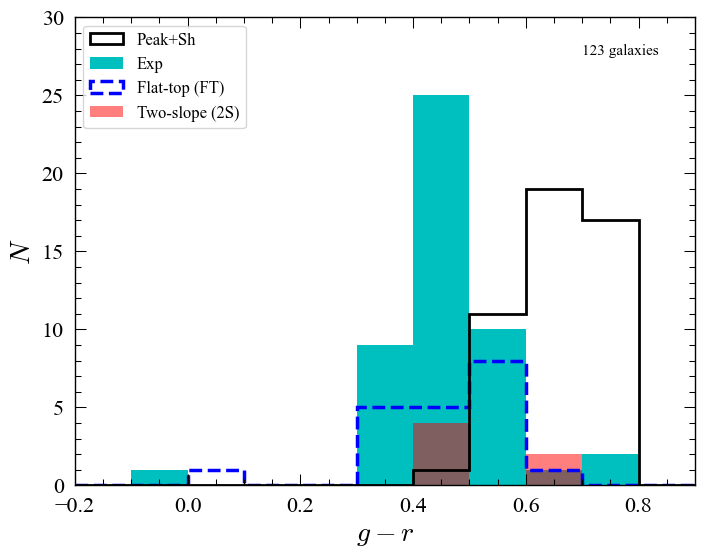

In [115]:
# Hubble-type distributions 
bins_htypes = np.arange(0,10,1)

figure();hist(s4gdata.t_leda[ii_s4g_exp_both], bins=bins_htypes, color='c', label='Exp')
hist(s4gdata.t_leda[ii_s4g_ft_both], bins=bins_htypes, histtype='step', color='b', lw=2.5, ls='--', label='Flat-top (FT)')
hist(s4gdata.t_leda[ii_s4g_2s_both], bins=bins_htypes, color='r', label='Two-slope (2S)', alpha=0.5)
hist(s4gdata.t_leda[ii_s4g_psh_both], bins=bins_htypes, histtype='step', color='k', lw=2, label=pshLabel)
ylim(0,22);xlim(-1,10)
ii_tot = ii_s4g_exp_both + ii_s4g_ft_both + ii_s4g_2s_both + ii_s4g_psh_both
ntot = len(ii_tot)
text(8, 0.92*22, "{:0d} galaxies".format(ntot), fontsize=11)
handles, labels = plt.gca().get_legend_handles_labels()
handles = [handles[3], handles[0], handles[1], handles[2]]
labels = [labels[3], labels[0], labels[1], labels[2]]
legend(handles, labels, loc='upper left', fontsize=12)
xlabel(r"Hubble type $T$");ylabel(r"$N$")
subplots_adjust(bottom=0.12)
if savePlots:
    savefig(fplots+"htypes_distributions_both.pdf")


# Gas mass fraction distributions
bins_logfgas = np.arange(-3,1.5,0.5)

figure();hist(s4gdata.logfgas[ii_s4g_exp_both], bins=bins_logfgas, color='c', label='Exp')
hist(s4gdata.logfgas[ii_s4g_ft_both], bins=bins_logfgas, histtype='step', color='b', lw=2.5, ls='--', label='Flat-top (FT)')
hist(s4gdata.logfgas[ii_s4g_2s_both], bins=bins_logfgas, color='r', label='Two-slope (2S)', alpha=0.5)
hist(s4gdata.logfgas[ii_s4g_psh_both], bins=bins_logfgas, histtype='step', color='k', lw=2, label=pshLabel)
ylim(0,24)
ii_tot = ii_s4g_exp_both + ii_s4g_ft_both + ii_s4g_2s_both + ii_s4g_psh_both
ntot = len(ii_tot)
text(0.3, 0.92*24, "{:0d} galaxies".format(ntot), fontsize=11)
handles, labels = plt.gca().get_legend_handles_labels()
handles = [handles[3], handles[0], handles[1], handles[2]]
labels = [labels[3], labels[0], labels[1], labels[2]]
legend(handles, labels, loc='upper left', fontsize=12)
xlabel(xtfgas);ylabel(r"$N$")
subplots_adjust(bottom=0.12)
if savePlots:
    savefig(fplots+"logfgas_distributions_both.pdf")


bins_gmr = np.arange(-0.2,1.0, 0.1)

# Single plot, using secure classifications only; labeled with number of galaxies
figure(3);clf();hist(s4gdata.gmr_sga_tc[ii_s4g_exp_both], bins=bins_gmr, color='c', label='Exp')
hist(s4gdata.gmr_sga_tc[ii_s4g_ft_both], bins=bins_gmr, histtype='step', color='b', lw=2.5, ls='--', label='Flat-top (FT)')
hist(s4gdata.gmr_sga_tc[ii_s4g_2s_both], bins=bins_gmr, color='r', label='Two-slope (2S)', alpha=0.5)
hist(s4gdata.gmr_sga_tc[ii_s4g_psh_both], bins=bins_gmr, histtype='step', color='k', lw=2, label=pshLabel)
xlim(-0.2,0.9);ylim(0,30)
ii_tot = ii_s4g_exp_both + ii_s4g_ft_both + ii_s4g_2s_both + ii_s4g_psh_both
ntot = len([i for i in ii_tot if s4gdata.gmr_sga_tc[i] > -1])
text(0.7, 0.92*30, "{:0d} galaxies".format(ntot), fontsize=11)
handles, labels = plt.gca().get_legend_handles_labels()
handles = [handles[3], handles[0], handles[1], handles[2]]
labels = [labels[3], labels[0], labels[1], labels[2]]
legend(handles, labels, loc='upper left', fontsize=12)
xlabel(xtgmr);ylabel(r"$N$")
subplots_adjust(bottom=0.12)
if savePlots:
    savefig(fplots+"gmr_distributions_both.pdf")


## Figure 8 -- Distributions of Bar-Profile Types Versus Bar Size and Strength

/var/folders/rj/3r6_hsl93l737byvn_vy_tmm0000gp/T/ipykernel_17408/514907817.py:2: RuntimeWarning: divide by zero encountered in divide
  sma_div_h = s4gdata.sma_dp_kpc2 / s4gdata.h_kpc
/var/folders/rj/3r6_hsl93l737byvn_vy_tmm0000gp/T/ipykernel_17408/514907817.py:2: RuntimeWarning: invalid value encountered in divide
  sma_div_h = s4gdata.sma_dp_kpc2 / s4gdata.h_kpc


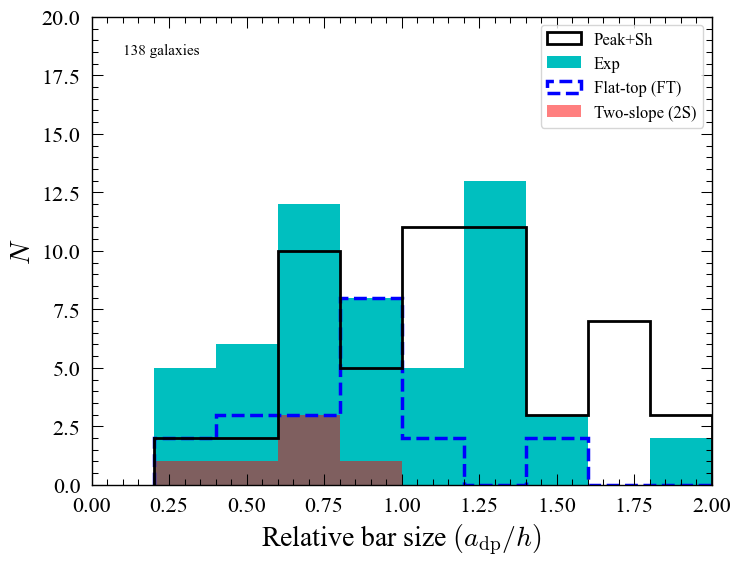

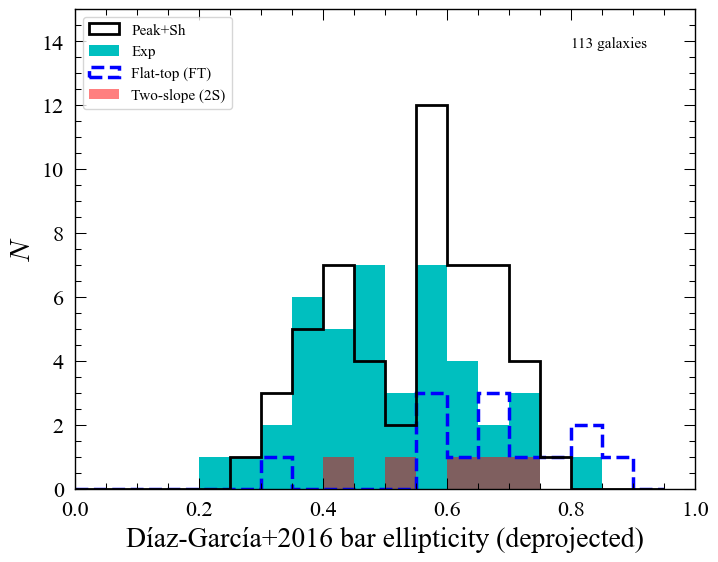

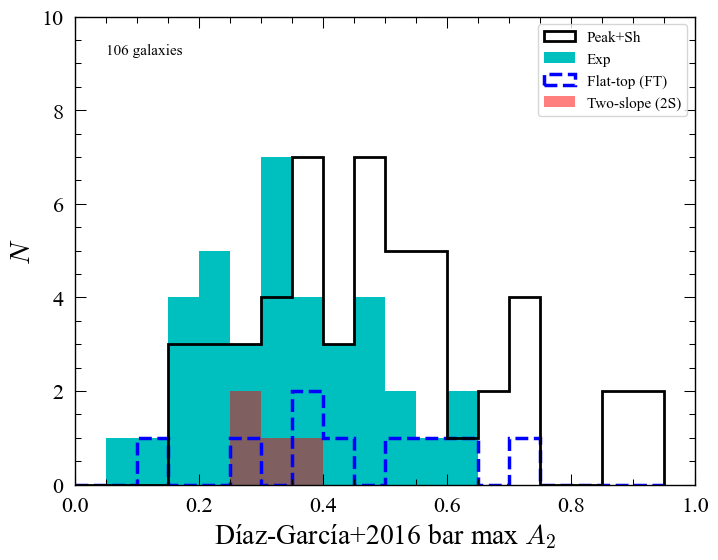

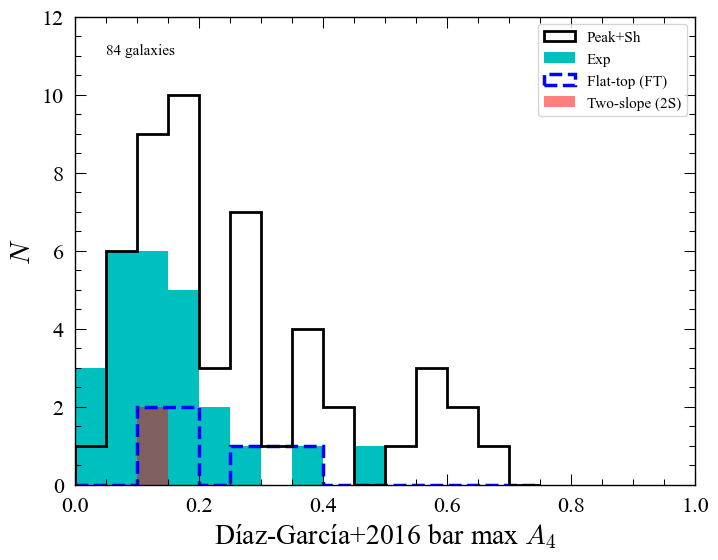

In [120]:
# Distributions of relative bar size (bar radus / galaxy disk scale length)
sma_div_h = s4gdata.sma_dp_kpc2 / s4gdata.h_kpc

bins_barsize = np.arange(0.2, 2.1, 0.2)

figure();hist(sma_div_h[ii_s4g_exp_both], bins=bins_barsize, color='c', label='Exp')
hist(sma_div_h[ii_s4g_ft_both], bins=bins_barsize, histtype='step', color='b', lw=2.5, ls='--', label='Flat-top (FT)')
hist(sma_div_h[ii_s4g_2s_both], bins=bins_barsize, color='r', label='Two-slope (2S)', alpha=0.5)
hist(sma_div_h[ii_s4g_psh_both], bins=bins_barsize, histtype='step', color='k', lw=2, label=pshLabel)
xlim(0,2.0);ylim(0,20)
ii_tot = ii_s4g_exp_both + ii_s4g_ft_both + ii_s4g_2s_both + ii_s4g_psh_both
ntot = len([i for i in ii_tot if sma_div_h[i] > 0])
text(0.1, 0.92*20, "{:0d} galaxies".format(ntot), fontsize=11)
handles, labels = plt.gca().get_legend_handles_labels()
handles = [handles[3], handles[0], handles[1], handles[2]]
labels = [labels[3], labels[0], labels[1], labels[2]]
legend(handles, labels, loc='upper right', fontsize=12)
xlabel(xtbarsize);ylabel(r"$N$")
subplots_adjust(bottom=0.12)
if savePlots:
    savefig(fplots+"barsize-rel_distributions_both.pdf")

# Distributions of bar strength: deprojected ellipticity
bins_ell_dp = np.arange(0.0,1.0,0.05)

figure();hist(s4gdata.ell_dp[ii_s4g_exp_both], bins=bins_ell_dp, color='c', label='Exp')   # 55 galaxies
hist(s4gdata.ell_dp[ii_s4g_ft_both], bins=bins_ell_dp, histtype='step', color='b', lw=2.5, ls='--', label='Flat-top (FT)')   # 21
hist(s4gdata.ell_dp[ii_s4g_2s_both], bins=bins_ell_dp, color='r', label='Two-slope (2S)', alpha=0.5)   # 6
hist(s4gdata.ell_dp[ii_s4g_psh_both], bins=bins_ell_dp, histtype='step', color='k', lw=2, label=pshLabel)   # 56
ylim(0,15)
ii_tot = ii_s4g_exp_both + ii_s4g_ft_both + ii_s4g_2s_both + ii_s4g_psh_both
ntot = len([i for i in ii_tot if s4gdata.ell_dp[i] > 0])
text(0.8, 0.92*15, "{:0d} galaxies".format(ntot), fontsize=11)
handles, labels = plt.gca().get_legend_handles_labels()
handles = [handles[3], handles[0], handles[1], handles[2]]
labels = [labels[3], labels[0], labels[1], labels[2]]
legend(handles, labels, loc='upper left', fontsize=11)
xlabel(r"Díaz-García+2016 bar ellipticity (deprojected)");ylabel(r"$N$")
if savePlots:
    savefig(fplots+"ell_dp_distributions_both.pdf")

# Distributions of bar strength: max(A_2)
bins_A2 = np.arange(0.0,1,0.05)

figure();hist(s4gdata.A2[ii_s4g_exp_both], bins=bins_A2, color='c', label='Exp')
hist(s4gdata.A2[ii_s4g_ft_both], bins=bins_A2, histtype='step', color='b', lw=2.5, ls='--', label='Flat-top (FT)')
hist(s4gdata.A2[ii_s4g_2s_both], bins=bins_A2, color='r', label='Two-slope (2S)', alpha=0.5)
hist(s4gdata.A2[ii_s4g_psh_both], bins=bins_A2, histtype='step', color='k', lw=2, label=pshLabel)
ylim(0,10)
ii_tot = ii_s4g_exp_both + ii_s4g_ft_both + ii_s4g_2s_both + ii_s4g_psh_both
ntot = len([i for i in ii_tot if s4gdata.A2[i] > 0])
text(0.05, 0.92*10, "{:0d} galaxies".format(ntot), fontsize=11)
handles, labels = plt.gca().get_legend_handles_labels()
handles = [handles[3], handles[0], handles[1], handles[2]]
labels = [labels[3], labels[0], labels[1], labels[2]]
legend(handles, labels, loc='upper right', fontsize=11)
xlabel(r"Díaz-García+2016 bar max $A_{2}$");ylabel(r"$N$")
subplots_adjust(bottom=0.12)
if savePlots:
    savefig(fplots+"ell_A2_distributions_both.pdf")

# Distributions of bar strength: max(A_4)
bins_A4 = np.arange(0.0,0.8,0.05)

figure();hist(s4gdata.A4[ii_s4g_exp_both], bins=bins_A4, color='c', label='Exp')
hist(s4gdata.A4[ii_s4g_ft_both], bins=bins_A4, histtype='step', color='b', lw=2.5, ls='--', label='Flat-top (FT)')
hist(s4gdata.A4[ii_s4g_2s_both], bins=bins_A4, color='r', label='Two-slope (2S)', alpha=0.5)
hist(s4gdata.A4[ii_s4g_psh_both], bins=bins_A4, histtype='step', color='k', lw=2, label=pshLabel)
ylim(0,12);xlim(0,1)
ii_tot = ii_s4g_exp_both + ii_s4g_ft_both + ii_s4g_2s_both + ii_s4g_psh_both
ntot = len([i for i in ii_tot if s4gdata.A4[i] > 0])
text(0.05, 0.92*12, "{:0d} galaxies".format(ntot), fontsize=11)
handles, labels = plt.gca().get_legend_handles_labels()
handles = [handles[3], handles[0], handles[1], handles[2]]
labels = [labels[3], labels[0], labels[1], labels[2]]
legend(handles, labels, loc='upper right', fontsize=11)
xlabel(r"Díaz-García+2016 bar max $A_{4}$");ylabel(r"$N$")
subplots_adjust(bottom=0.12)
if savePlots:
    savefig(fplots+"ell_A4_distributions_both.pdf")


## Figure 9 -- Frequency of B/P Bulges Versus Stellar Mass

In [137]:
logmstar_modinc = np.array([stellarMassDict_main[gname] for gname in modinc_names])
junk,gdict_morph = barprof_utils.GetGalaxyNamesAndDict_morphology()

ii_bp = [i for i in range(nModInc) if gdict_morph[modinc_names[i]] == "B/P"]
ii_nonbp = [i for i in range(nModInc) if gdict_morph[modinc_names[i]] != "B/P"]

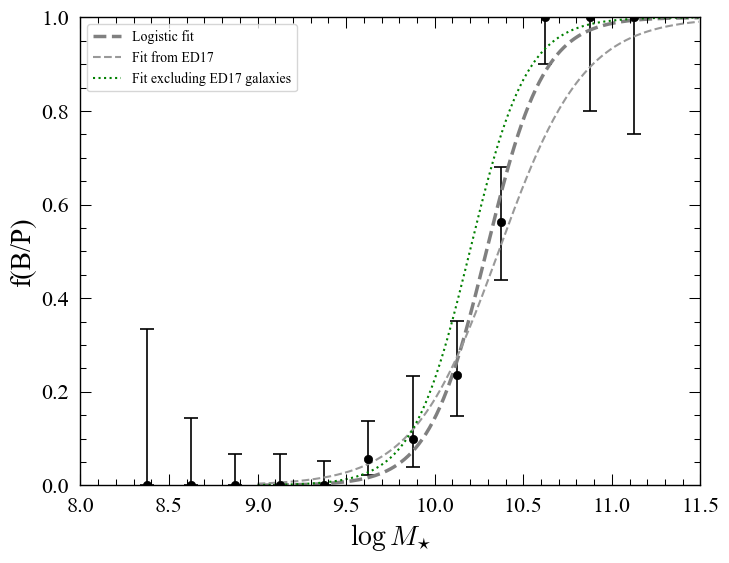

In [154]:
mm = np.arange(9,11.5, 0.01)
# coefficients of logistic fits (ed17 = fit from Erwin & Debattista 2017)
coeffs_bpmorph = [-63.006435900515456, 6.122222852940198]
coeffs_ed17 = [-42.79, 4.13]
coeffs_noned17 = [-63.124788674436815, 6.1900522187150075]

pu.PlotFrequency(logmstar_modinc, ii_bp, ii_nonbp, 8.0, 11.5, 0.25, fmt='ko')
plot(mm, logistic(mm,coeffs_bpmorph[0],coeffs_bpmorph[1]), '0.5', ls='--', lw=2.5, label="Logistic fit")
tt17 = "Fit from ED17"
plot(mm, logistic(mm,coeffs_ed17[0],coeffs_ed17[1]), '0.6', ls='--', lw=1.5, label=tt17)
tt_non17 = "Fit excluding ED17 galaxies"
plot(mm, logistic(mm,coeffs_noned17[0],coeffs_noned17[1]), 'g', ls=':', lw=1.5, label=tt_non17)
legend(fontsize=10)
xlabel(r"$\log M_{\star}$");ylabel("f(B/P)")
subplots_adjust(bottom=0.12)
if savePlots:
    savefig(fplots + "f_BPmorph_vs_logmstar_logistic-fits.pdf")


## Figure 10 -- Frequency of B/P Bulges Versus Rotation Velocity

In [151]:
vrotDict = {}
for i in range(nDisksTotal):
    gname = s4gdata.name[i]
    vrot = s4gdata.V_rot[i]
    if (vrot <= 0):
        log_vrot = -99
    else:
        log_vrot = math.log10(vrot)
    vrotDict[gname] = log_vrot

logvrot_modinc = np.array([vrotDict[gname] for gname in modinc_names])


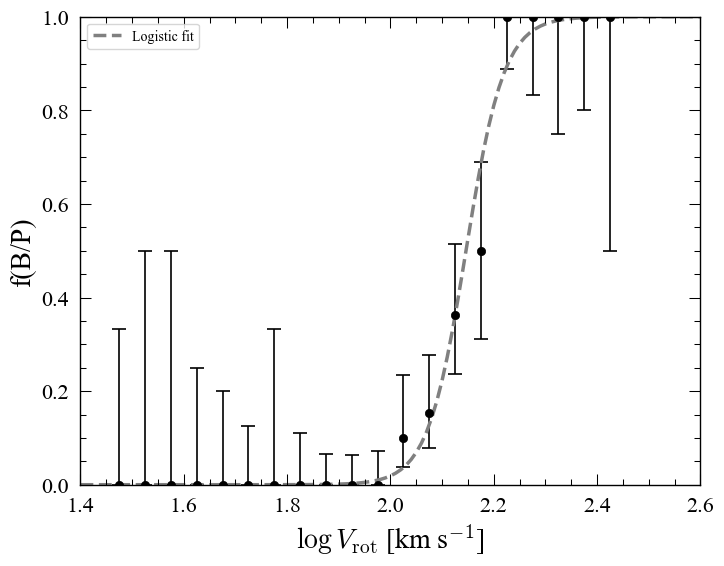

In [153]:
vv = np.arange(1.4, 2.6, 0.01)
# coefficients of logistic fit
coeffs_vrot = [-57.964663254824956, 27.008022585107422]

pu.PlotFrequency(logvrot_modinc, ii_bp, ii_nonbp, 1.4,2.5,0.05, fmt='ko')
plot(vv, logistic(vv,coeffs_vrot[0],coeffs_vrot[1]), '0.5', ls='--', lw=2.5, label="Logistic fit")
#axvline(math.log10(120.0), color='b', linestyle='--', label=r"$V_{\rm rot} = 120$ km/s")
xlabel(r"$\log V_{\rm rot}$ [km s$^{-1}$]");ylabel("f(B/P)")
legend(loc='upper left', fontsize=10)
subplots_adjust(bottom=0.12)
if savePlots:
    savefig(fplots + "f_BPmorph_vs_logVrot.pdf")


## Figure 11 -- Frequency of P+Sh Profiles Versus Stellar Mass

In [160]:
coeffs_psh_pe = [-46.69821364293907, 4.611871122156639]
coeffs_psh_vd = [-50.61399257635582, 5.018288081365982]

logmstar_s4g, ii_bp_pe,ii_nonbp_pe = barprof_utils.GetValuesAndIndices(pd, stellarMassDict_main)
logmstar_s4g, ii_bp_vd,ii_nonbp_vd = barprof_utils.GetValuesAndIndices(vd, stellarMassDict_main)

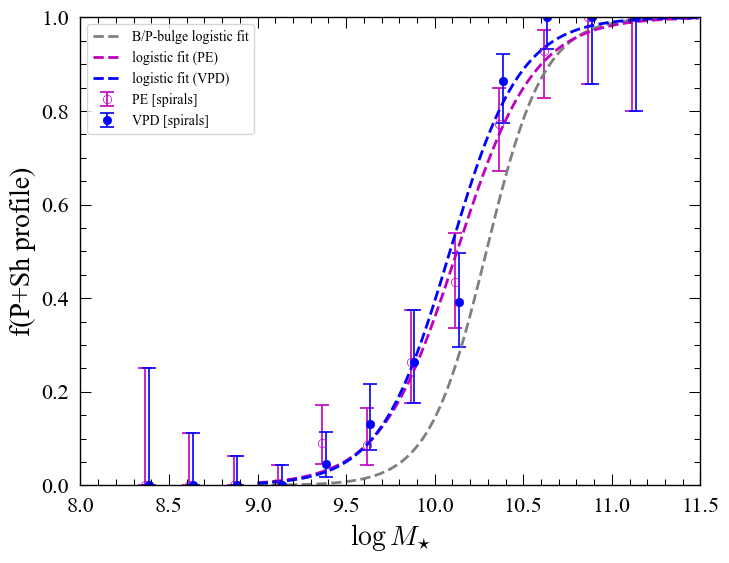

In [161]:
# Coefficients of logistic fit to P+Sh profile presence vs stellar mass
t1 = 'B/P-bulge logistic fit'
t2 = 'logistic fit (PE)'
t3 = 'logistic fit (VPD)'

pu.PlotFrequency(logmstar_s4g, ii_bp_pe, ii_nonbp_pe, 8.0, 11.5, 0.25, offset=-0.01, fmt='mo', mfc='None', label='PE [spirals]')
pu.PlotFrequency(logmstar_s4g, ii_bp_vd, ii_nonbp_vd, 8.0, 11.5, 0.25, offset=0.01, fmt='bo', label='VPD [spirals]', noErase=True)
plot(mm, astrostat.logistic(mm,coeffs_bpmorph[0],coeffs_bpmorph[1]), '0.5', ls='--', lw=2, label=t1)
plot(mm, astrostat.logistic(mm,coeffs_psh_pe[0],coeffs_psh_pe[1]), 'm', ls='--', lw=2, label=t2)
plot(mm, astrostat.logistic(mm,coeffs_psh_vd[0],coeffs_psh_vd[1]), 'b', ls='--', lw=2, label=t3)
legend(fontsize=10)
xlabel(r"$\log M_{\star}$");ylabel("f(P+Sh profile)")
subplots_adjust(bottom=0.12)
if savePlots:
    savefig(fplots + "f_BPprofile_vs_logmstar_spirals.pdf")

## Figure A1 -- Examples of Classification Plots

### Useful Functions

### Subsamples

Importing the variables defined in `sample_defs.py` provides lists of int values, which can be used to index numpy 1D arrays, thereby defining different subsamples of S4G.

E.g., the R_e values of all the barred galaxies can be defined as
    
    s4gdata.Re_kpc[ii_barred]

**Location of subsample definitions:** 

projDir + sample_defs.py

In [5]:
from sample_defs import *

For reference, here are the definitions in that file: